In [2]:
import pandas as pd

import string
import re
sys.path.insert(1, '/Users/lifeifan/Desktop/ece1786/project/')
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

from sklearn.model_selection import train_test_split
import numpy as np

import nltk
import data_cleaning
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()

nltk.download('wordnet')
nltk.download('stopwords')

import nltk


from nltk.stem import PorterStemmer

lemmatizer = WordNetLemmatizer()

# import tensorflow as tf

df = pd.read_csv("../PolitiTrend/r_and_l.csv")

df['cmp_code'] = df['cmp_code'].replace({'laissez-faire': 0, 'regulationism': 1})
df = df.rename(columns={'cmp_code': 'label'})





showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lifeifan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lifeifan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lifeifan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lifeifan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
cleaned_data = data_cleaning.remove_stop_words(df,"text","cleaned_text")
cleaned_data = data_cleaning.remove_punctuations(cleaned_data,"cleaned_text","cleaned_text")
cleaned_data = data_cleaning.lemm_text(cleaned_data,"cleaned_text","cleaned_text")

In [5]:
from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [7]:
texts = cleaned_data.cleaned_text.values
labels = df.label.values

In [8]:
train_input, val_input, train_label, val_label=train_test_split (texts, labels)

In [9]:
print(len(val_input))

500


In [10]:
max_len = 0
for content in texts:
    max_len = max(max_len, len(content))
print('Max sentence length: ', max_len)


Max sentence length:  371


In [11]:
print("token",tokenizer.convert_tokens_to_ids(tokenizer.tokenize(texts[0])))

token [3174, 2454, 2111, 4227, 2740, 5427, 6325]


In [12]:
import torch
import tensorflow as tf
def mask_inputs_for_bert (text,max_len):
    attention_masks = []
    input_ids = []
    i = 0
    for content in text:

        encoded_dict = tokenizer.encode_plus(
            content,
            add_special_tokens = True, 
            max_length= max_len,
            pad_to_max_length = True,
            return_attention_mask = True, 
        )


        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

        #convert to tensor and return
    input_ids = tf.convert_to_tensor(input_ids)
    attention_masks = tf.convert_to_tensor(attention_masks)
    return input_ids, attention_masks

In [13]:
train_inp, train_mask = mask_inputs_for_bert (train_input,max_len) 
val_inp, val_mask = mask_inputs_for_bert (val_input, max_len) 
train_label =  tf.convert_to_tensor(train_label)
val_label =  tf.convert_to_tensor(val_label)
print("Train_input_shape", train_inp.shape) 
print("Train_mask_shape", train_mask.shape) 
print("Validation_input_shape", val_inp.shape) 
print("Validation_mask_shape", val_mask.shape) 
print("Train_labelshape", train_label.shape) 
print("Validation_label_shape", val_label.shape)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train_input_shape (1500, 371)
Train_mask_shape (1500, 371)
Validation_input_shape (500, 371)
Validation_mask_shape (500, 371)
Train_labelshape (1500,)
Validation_label_shape (500,)


In [14]:
print(train_inp)

tf.Tensor(
[[ 101 2065 2113 ...    0    0    0]
 [ 101 1999 2344 ...    0    0    0]
 [ 101 2057 2036 ...    0    0    0]
 ...
 [ 101 1996 4093 ...    0    0    0]
 [ 101 2057 4190 ...    0    0    0]
 [ 101 1037 3663 ...    0    0    0]], shape=(1500, 371), dtype=int32)


In [15]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:

log_dir='/Users/lifeifan/Desktop/ece1786/project/'
model_save_path='/Users/lifeifan/Desktop/ece1786/project/bert2.h5'
callbacks = [tf.keras.callbacks. ModelCheckpoint (filepath=model_save_path,
                                                    save_weights_only=True,
                                                    monitor= 'val_loss', 
                                                    mode='min',
                                                    save_best_only=True),
                                                    tf.keras.callbacks.TensorBoard (log_dir=log_dir)]
print('\nBert Model', model.summary())
loss = tf.keras.losses. SparseCategoricalCrossentropy (from_logits=True) 
metric = tf.keras.metrics. SparseCategoricalAccuracy('accuracy')
optimizer= tf.keras.optimizers.legacy.Adam (learning_rate=2e-5, epsilon=1e-08)
model.compile(loss=loss, optimizer=optimizer, metrics=[metric])

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Bert Model None


In [22]:
history=model.fit([train_inp, train_mask],
                    train_label,
                    batch_size=32,
                    epochs=4,
                    validation_data=([val_inp, val_mask], val_label),
                    callbacks=callbacks)

Epoch 1/2
47/47 [==============================] - 3067s 65s/step - loss: 0.1447 - accuracy: 0.9500 - val_loss: 0.6293 - val_accuracy: 0.7680
Epoch 2/2
47/47 [==============================] - 1894s 40s/step - loss: 0.0675 - accuracy: 0.9800 - val_loss: 0.8069 - val_accuracy: 0.7500


In [18]:
print(history)

In [19]:
train_acc = [0.6153,0.7753,0.8700,0.9447]
validation_acc = [0.7340,0.7420,0.7620,0.7860]

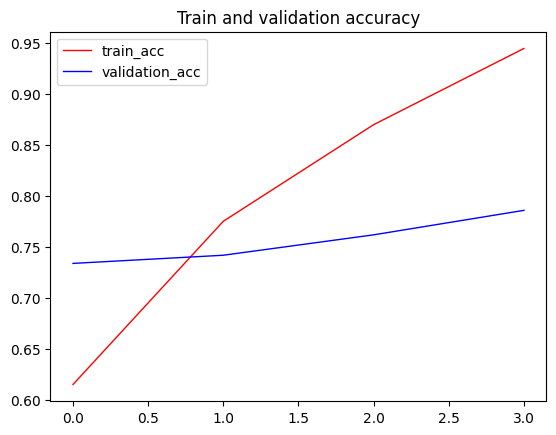

In [20]:

plt.plot(train_acc, color="r", linestyle="-", linewidth=1)  
plt.plot(validation_acc, color="b", linestyle="-",  linewidth=1)
plt.title('Train and validation accuracy')
plt.legend(["train_acc", "validation_acc"])

In [21]:
import matplotlib.pyplot as plt
# plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_accuracy'], label='validation accuracy')

TypeError: 'History' object is not subscriptable

In [ ]:
import tensorflow as tf
from transformers import BertTokenizerFast,TFBertForSequenceClassification
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=2)
model.load_weights('/Users/lifeifan/Desktop/ece1786/project/bert.h5')



All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import f1_score
preds = model.predict([val_inp,val_mask],batch_size=32)

NameError: name 'val_inp' is not defined

In [ ]:
pred_labels = preds.logits.argmax(axis=1)
f1 = f1_score(val_label,pred_labels)
print('F1 score',f1)
print('Classification Report')
# print(classification_report(val_label,pred_labels,target_names=target_names))

print('Training and saving built model.....') 


NameError: name 'preds' is not defined

In [ ]:


import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification

# Load the pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

# Preprocess your single sentence
# input_text = "Respect for women's rights and interests"
input_text = "Respect for traditional ethical values"

input_ids = tokenizer.encode(input_text, add_special_tokens=True, return_tensors="tf")
predictions = model(input_ids)
import numpy as np

logits = predictions.logits
probabilities = tf.nn.softmax(logits, axis=1)
print(probabilities)
predicted_class = tf.argmax(probabilities, axis=1)
print(predicted_class)

class_labels = ['con', 'pro']
predicted_label = class_labels[predicted_class.numpy()[0]]
print(predicted_class)

tf.Tensor([[0.4221253  0.57787466]], shape=(1, 2), dtype=float32)
tf.Tensor([1], shape=(1,), dtype=int64)
tf.Tensor([1], shape=(1,), dtype=int64)
